In [1]:
#INIZIALIZZAZIONE AMBIENTE
import os
import torch
import torchaudio
import torchaudio.transforms as T
import soundfile as sf
import numpy as np
import librosa
from tqdm import tqdm
import random
import subprocess
from torch import nn
import warnings
import re

!pip install pyloudnorm

from dataclasses import dataclass
from typing import List, Literal
import numpy as np, math
from scipy.signal import lfilter, butter

import matplotlib.pyplot as plt
import librosa.display
import numpy as np
from matplotlib.gridspec import GridSpec

warnings.filterwarnings("ignore")

#CONFIGURAZIONE DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilizzo dispositivo: {device}")



Utilizzo dispositivo: cuda


**EQUALIZZATORE PARAMETRICO**

L'equalizzatore parametrico, che processa l'audio dopo il restauro Demucs, è implementato principalmente nella funzione 'apply_parametric_eq' e utilizza diverse funzioni helper per creare i filtri specifici, definiti dalla dataclass 'EqBand'.

In [2]:
#DEFINIAMO IL NOSTRO EQUALIZZATORE PARAMETRICO

EqType = Literal["peak", "lowshelf","highshelf", "lowpass","highpass"] #FILTRI

@dataclass
class EqBand: #Questa dataclass definisce la struttura di ogni singola banda dell'equalizzatore
  kind: EqType #Specifica il tipo di filtro('peak','lowshelf','highshelf','lowpass','highpass')
  fc: float #La frequenza centrale o di taglio del filtro in Hz
  gain_db: float = 0.0 #Il guadagno in decibel(solo per filtri 'peak','lowshelf','highshelf')--> Indica di quanto aumentare o diminuire l'energia a quella frequenza
  Q: float = 0.707 #Il fattore di qualità(solo per filtri 'peak','lowshelf','highshelf')--> Controlla l'ampiezza della banda di frequenze influenzata(un Q più alto significa una banda più stretta)
  order: int = 2 #L'ordine del filtro(solo per filtri 'lowpass','highpass')--> Determina la pendenza del taglio(un ordine più alto rende il taglio più ripido)


#FUNZIONI HELPER PER I BIQUAD FILTERS: Queste funzioni calcolano i coefficienti(b e a)
#per i filtri biquad(filtri IIR(= Infinite-Impulse Response) di secondo ordine).-->I coefficienti
#b e a sono essenziali per la funzione lfilter di scipy, che applica il filtro al segnale audio.
#Ogni tipo di filtro(peak,lowshelf,highshelf) ha una formula matematica specifica
#per calcolare questi coefficienti in base alla frequenza di campionamento(fs),
#frequenza centrale/di taglio(fc), guadagno(gain_db) e fattore Q.
def _biquad_peak(fs,fc,gain_db,Q):
  A = 10**(gain_db/40)
  w0 = 2*math.pi*fc/fs
  alpha = math.sin(w0)/(2*Q)
  cosw0 = math.cos(w0)
  b0 = 1 + alpha*A
  b1 = -2*cosw0
  b2 = 1 - alpha*A
  a0 = 1 + alpha/A
  a1 = -2*cosw0
  a2 = 1 - alpha/A
  b = np.array([b0/a0,b1/a0,b2/a0],dtype=np.float64)
  a = np.array([1.0,a1/a0,a2/a0],dtype=np.float64)
  return b,a

def _biquad_lowshelf(fs,fc,gain_db,Q):
  A = 10**(gain_db/40)
  w0 = 2*math.pi*fc/fs
  alpha = math.sin(w0)/(2*Q)
  cosw0 = math.cos(w0)
  sqrtA = math.sqrt(A)
  b0 = A*((A+1)-(A-1)*cosw0+2*sqrtA*alpha)
  b1 = 2*A*((A-1)-(A+1)*cosw0)
  b2 = A*((A+1)-(A-1)*cosw0-2*sqrtA*alpha)
  a0 = (A+1)+(A-1)*cosw0+2*sqrtA*alpha
  a1 = -2*((A-1)+(A+1)*cosw0)
  a2 = (A+1)+(A-1)*cosw0-2*sqrtA*alpha
  b = np.array([b0/a0,b1/a0,b2/a0],dtype=np.float64)
  a = np.array([1.0,a1/a0,a2/a0],dtype=np.float64)
  return b,a

def _biquad_highshelf(fs,fc,gain_db,Q):
  A = 10**(gain_db/40)
  w0 = 2*math.pi*fc/fs
  alpha = math.sin(w0)/(2*Q)
  cosw0 = math.cos(w0)
  sqrtA = math.sqrt(A)
  b0 = A*((A+1) + (A-1)*cosw0 + 2*sqrtA*alpha)
  b1 = -2*A*((A-1)+(A+1)*cosw0)
  b2 = A*((A+1)+(A-1)*cosw0 - 2*sqrtA*alpha)
  a0 = (A+1) - (A-1)*cosw0 + 2*sqrtA*alpha
  a1 = 2*((A-1)-(A+1)*cosw0)
  a2 = (A+1)-(A-1)*cosw0 - 2*sqrtA*alpha
  b = np.array([b0/a0,b1/a0,b2/a0],dtype=np.float64)
  a = np.array([1.0,a1/a0,a2/a0],dtype=np.float64)
  return b,a


#FUNZIONE HELPER PER I BUTTER FILTERS:Questa funzione utilizza la libreria
#scipy.signal.butter per calcolare i coefficienti per filtri Butterworth lowpass o highpass.
#La funzione richiede la frequenza di campionamento(fs), la frequenza di taglio(fc),
#il tipo('lowpass' o 'highpass') e l'ordine(order).
def _butter_filter(fs, fc, kind: EqType, order=2):
  wn = fc/(fs/2)
  wn = min(max(wn, 1e-4), 0.999) #stabilità numerica
  b, a = butter(order, wn, btype='low' if kind=="lowpass" else 'high')
  return np.asarray(b, float), np.asarray(a, float) #Anche questa funzione restituisce i coefficienti b e a necessari per lfilter


#FUNZIONE PRINCIPALE: Applica in cascata le bande EQ al nostro segnale audio 'y' (mono o stereo [n,2])
#e ritorna float32 con stesso shape.
def apply_parametric_eq(y: np.ndarray, sr: int, bands: List[EqBand]) -> np.ndarray: #Dove abbiamo in input anche il sample rate(sr) e una lista di oggetti EqBand
   if y.ndim == 2 and y.shape[1] == 2:
    #Se l'audio è stereo, processa i canali sinistro e destro(L\R)
    #separatamente ma con gli stessi filtri per mantenere la coerenza.
    L = apply_parametric_eq(y[:,0], sr, bands)
    R = apply_parametric_eq(y[:,1], sr, bands)
    return np.stack([L, R], axis=1).astype(np.float32)

   x = y.astype(np.float64, copy=False)
   for b in bands: #Itera attraverso ogni EqBand nella lista
    #Per ogni banda, determina il tipo di filtro e chiama la funzione helper appropriata
    #per ottenere i coefficienti b e a.
    if b.kind == "peak":
      B, A = _biquad_peak(sr, b.fc, b.gain_db, b.Q)
    elif b.kind == "lowshelf":
      B, A = _biquad_lowshelf(sr, b.fc, b.gain_db, b.Q)
    elif b.kind == "highshelf":
      B, A = _biquad_highshelf(sr, b.fc, b.gain_db, b.Q)
    elif b.kind in ("lowpass", "highpass"):
      B, A = _butter_filter(sr, b.fc, b.kind, b.order)
    else:
      continue
    #Applichiamo ora il filtro al segnale audio utilizzando scipy.signal.lfilter(B,A,x).
    #Questo applica i coefficienti B e A al segnale x per filtrarlo.--> La funzione
    #lfilter esegue una differenza finita che corrisponde alla funzione di trasferimento del
    #filtro definita dai coefficienti.
    x = lfilter(B, A, x) #--> In questo modo, il risultato di un filtro diventa l'input per il filtro successivo, creando una cascata di filtri.
   #Normalizzazione anti-clip soft (che non cambia LUFS in modo significativo)--> Per evitare
   #il clipping(=superamento del valore massimo consentito per l'audio digitale, che causerebbe distorsione)
   #se il picco supera 1.0.
   peak = np.max(np.abs(x)) + 1e-12
   if peak > 1.0:
     x = x/peak
   return x.astype(np.float32)

In [3]:
#Funzione per creare nomi file sicuri--> Questa funzione utility rimuove caratteri speciali dai nomi dei file
def create_safe_filename(text, max_length=30):
    """Crea un nome file sicuro rimuovendo caratteri speciali"""
    #Sostituisci spazi con underscore
    safe_text = re.sub(r'\s+', '_', text)
    #Rimuovi caratteri non alfanumerici
    safe_text = re.sub(r'[^a-zA-Z0-9_]', '', safe_text)
    #Limita la lunghezza(per compatibiltà con diversi filesystem)
    return safe_text[:max_length]

**TEXT-CONDITIONAL GENERATION**

In [4]:
#DEFINIAMO ADESSO LA FUNZIONE 'generate_samples' PER GENERARE I NOSTRI SAMPLES DA MUSICGEN,
#SALVANDOLI IN UNA SPECIFICA DIRECTORY

#La funzione accetta 2 parametri: la directory di output e il numero di campioni per categoria
def generate_samples(output_dir="raw_samples", num_samples_per_category=5): #Voglio generare 5 samples per ogni categoria, per evitare squilibri nel dataset
    import time #Viene importato il modulo time per le pause tra le generazioni
    os.makedirs(output_dir, exist_ok=True) #Crea la directory di output se non esiste
    #Importiamo qui i moduli necessari
    from transformers import AutoProcessor, MusicgenForConditionalGeneration #Si caricano i componenti necessari di Hugging Face Transformers
    import scipy.io.wavfile as wavfile #Si importa scipy per salvare i file audio

    print("Caricamento modello MusicGen...")

    # Carica modello e processore
    processor = AutoProcessor.from_pretrained("facebook/musicgen-small") #Si carica il processore per preparare gli input testuali
    model = MusicgenForConditionalGeneration.from_pretrained("facebook/musicgen-small") #Si carica il modello MusicGen nella versione "small"
    model.to(device) #Il modello viene spostato sulla GPU (se disponibile) per l'elaborazione accelerata

    #DEFINIAMO LE CATEGORIE E I LORO PROMPTS PER LA GENERAZIONE AUDIO
    #Definiamo diverse categorie principali su cui fare testing: All'interno della categoria,
    #vengono elencati diversi prompt descrittivi(ogni prompt descrive un tipo specifico di musica o suono).
    #Tra le categorie includiamo anche quella del cantato('Musica con voce'), perchè, nonostante
    #MusicGen non sia progettato per generare voci umane realistiche e ciò che produce in
    #risposta a prompt vocali sono spesso vocalizzi non linguistici o suoni simili a cori,
    #è rilevante per il nostro progetto includere anche samples di questo tipo.
    categories = {
        "Strumenti singoli": [
            "jazz piano solo", "classical guitar piece",
            "acoustic bass groove", "violin sonata",
            "saxophone improvisation"

        ],
        "Ensemble musicali": [
            "jazz trio piano bass drums", "string quartet classical",
            "rock band guitar drums bass",
            "marching band brass percussion",
            "folk band fiddle banjo guitar"
        ],
        "Generi elettronici": [
            "techno beat 130 bpm", "dubstep wobbly bass",
            "house music piano", "drum and bass fast",
            "chillout downtempo"
        ],
        "Musica con voce": [
            "female pop vocal catchy chorus", "rap verse with beatbox",
            "opera tenor aria powerful", "male rock vocal gritty",
            "R&B soulful female vocal"
        ],
        "Effetti": [
            "epic battle scene with swords and dragons",
            "rainstorm with thunder and wind",
            "busy city street with traffic and people",
            "forest with animals and streams",
            "spaceship engine and sci-fi effects"
        ],
        "Distorti": [    #La categoria "Distorti" include prompt per audio con distorsioni intenzionali
            "8-bit video game music with intentional glitches",
            "low quality radio broadcast with noise",
            "overcompressed pop song with artifacts",
            "vinyl record with heavy scratches and crackle",
            "heavily distorted guitar with digital clipping"

        ]
      }


    #GENERA DATASET: Per ogni categoria e prompt, generiamo un audio sample.
    #Per ogni categoria nelle categorie definite: si stampa il nome della categoria e
    #si seleziona un sottoinsieme casuale di prompt (il numero specificato o tutti se sono meno)
    print("Generazione campioni principali...")
    total_samples = 0

    for cat_name, prompts in categories.items():
        print(f"\nGenerando categoria: {cat_name}")

        #Seleziona un sottoinsieme di prompt per questa categoria
        selected_prompts = random.sample(prompts, min(num_samples_per_category, len(prompts)))
        #Per ogni prompt selezionato: si sceglie una durata casuale tra 5 e 10 secondi e
        #si crea un prefisso per il nome del file basato sulla categoria
        for prompt in tqdm(selected_prompts, desc=f"Generating {cat_name}"):
            try:
                duration = random.randint(5, 10)
                prefix = f"{cat_name[:3].lower()}_{create_safe_filename(cat_name)[:10]}" #Si crea un prefisso per il nome del file basato sulla categoria

                # Prepara l'input
                inputs = processor(    #Il processore trasforma il prompt testuale in un formato che il modello può comprendere
                    text=[prompt],
                    padding=True,
                    return_tensors="pt", #Il testo viene convertito in tensori PyTorch
                ).to(device)           #I tensori vengono spostati sul dispositivo appropriato (GPU/CPU)

                #USIAMO IL MODELLO PER GENERARE AUDIO DAL PROMPT TESTUALE
                audio_values = model.generate(
                    **inputs,  #Il modello genera audio basato sul prompt testuale
                    max_new_tokens=int(duration * 50),  #max_new_tokens controlla la lunghezza dell'audio generato (circa 50 token al secondo)
                    do_sample=True    #do_sample=True abilita la generazione casuale invece di una generazione deterministica
                )
                #ORA SALVIAMO L'AUDIO GENERATO COME WAV FILE
                #Estrai l'audio e converti in numpy# MusicGen usa 32kHz--> Il sample rate è fissato a 32kHz (valore predefinito di MusicGen), anche se in
                audio = audio_values[0, 0].cpu().numpy()  #L'audio generato viene estratto dai tensori PyTorch: viene convertito in un array NumPy per l'elaborazione successiva
                #MusicGen usa 32kHz--> Il sample rate è fissato a 32kHz (valore predefinito di MusicGen), anche se,
                #in realtà, Demucs è stato ottimizzato per sample rate pari a 44.1 kHz, che è
                #anche lo standard per l'industria musicale(molti software e dispositivi si
                #aspettano audio a 44.1 kHz)
                sr = 32000

                #Creazione filename sicuro--> Il nome del file viene reso "sicuro" rimuovendo caratteri speciali
                safe_prompt = create_safe_filename(prompt)
                filename = f"{prefix}_{safe_prompt}.wav"
                filepath = os.path.join(output_dir, filename) #Il file viene salvato nella directory di output

                #Salva con scipy per evitare problemi(per evitare problemi di compatibilità con altre librerie)
                #con torchaudio/soundfile
                wavfile.write(filepath, sr, audio)

                total_samples += 1 #Il contatore dei campioni totali viene incrementato
                torch.cuda.empty_cache() #La cache della GPU viene liberata dopo ogni generazione per prevenire problemi di memoria

                #Pausa breve per evitare sovraccarico della GPU: viene inserita una pausa di 1 secondo per evitare sovraccarico della GPU
                time.sleep(1)

            except Exception as e: #Gli errori vengono catturati e visualizzati senza interrompere l'intero processo
                print(f"Errore generazione {prompt}: {str(e)}")

    print(f"\nTotale campioni generati: {total_samples}") #Alla fine, viene stampato il numero totale di campioni generati

**CARICAMENTO DEL MODELLO DEMUCS**

Demucs è un modello di AI generativa sviluppato con lo scopo di separare un audio negli stems che lo costituiscono, come voce, percussioni, bassi e altri strumenti. Demucs viene principalmente utilizzato nella produzione e ricerca musicale, permettendo una vasta gamma di operazioni, quali remixing, sampling e la generazione anche di audio destinati al karaoke.

Nonostante i suoi sorprendenti utilizzi, Demucs e il suo design transformer-based presentano delle limitazioni. I transformers infatti richiedono un'ingente quantità di labeled data per ottenere risultati ottimali; inoltre, modelli sperimentali a 6 sorgenti (con l'aggiunta di piano e chitarra) presentano importanti distorsioni e artefatti, in particolare per quanto riguarda la sorgente del piano.

In [5]:
#DEFINIAMO ORA LA FUNZIONE 'load_demucs_' che carica il modello Demucs e la funzione apply_model
def load_demucs(): #Questa funzione importa le funzioni necessarie dalla libreria Demucs.
    from demucs.pretrained import get_model
    from demucs.apply import apply_model
    print("Caricamento modello Demucs...")
    #Mentre htdemucs(trained on MusDB + 800 songs) è la prima versione di Hybrid Trasformer Demucs, htdemucs_ft ne è la
    #versione fine-tuned.
    model = get_model('htdemucs_ft')
    #Il modello viene spostato sul device specificato(GPU se è disponibile) e impostato in modalità 'valutazione'
    model.to(device)
    model.eval()
    return model, apply_model #Ritorniamo il modello e la funzione apply_model


**PIPELINE DI RESTAURO**

La pipeline qui implementata prevede l'uso di Demucs, seguito dall'applicazione di un equalizzatore parametrico con preset standard e della normalizzazione LUFS.

In [6]:
#DEFINIAMO LA CLASSE 'DemucsRestorer' CHE USA IL MODELLO CARICATO PER LA RESTAURAZIONE AUDIO
class DemucsRestorer:
    def __init__(self, sample_rate=44100): #La classe viene inizializzata con un sample rate(default 44100 Hz)
        self.sample_rate = sample_rate
        self.demucs, self.apply_demucs = load_demucs() #Nel metodo __init__, carichiamo il modello Demucs e la funzione apply_model  richiamando la funzione 'load_demucs'

        #Pesi fissi per la fusione: Settiamo pesi fissi per le quattro sorgenti(vocals, bass, drums, other)
        #sotto forma di tensore [0.25, 0.25, 0.25, 0.25],
        #ovvero settiamo pesi uguali per ogni sorgente.
        #Assicuriamoci che i pesi siano sul device corretto e che siano 3D per
        #il broadcasting con (sources,channels,samples).
        self.source_weights = torch.tensor([0.25, 0.25, 0.25, 0.25], device=device).view(4, 1, 1) #Il tensore ha una shape (4, 1, 1)

    def enhance(self, audio): #Ha come input un tensore la cui shape dovrebbe essere (channels,samples) dopo il preprocessing.
        print(f"Enhance input shape: {audio.shape}") #Printiamo la shape dell'input.

        #Assicuriamoci che l'audio sia sul device corretto e in float32.
        audio = audio.to(device).float()

        #Demucs si aspetta (batch, channels, samples)
        audio_batch = audio.unsqueeze(0) #Aggiungiamo una dimensione batch('unsqueezing' the tensor), perchè Demucs si aspetta (batch,channels,samples)

        print(f"Shape before apply_demucs: {audio_batch.shape}") #Printiamo la shape dopo aver aggiunto una dimensione batch

        #SEPARAZIONE DELLE SORGENTI CON DEMUCS(Abbiamo disabilitato il calcolo dei gradienti (per risparmiare memoria durante l'inferenza))
        with torch.no_grad(): #Applichiamo il modello Demucs per separare l'audio in 4 sorgenti(vocals, bass, drums, other) senza gradiente.
            #Passiamo audio_batch
            #apply_model si aspetta infatti un audio dalla shape (batch, channels, samples)
            sources = self.apply_demucs(self.demucs, audio_batch, device=device)
            #Le sorgenti in output divrebbero essere del tipo(batch, sources, channels, samples)
            print(f"Sources shape after apply_demucs: {sources.shape}")

            #L'output di apply_model ha shape(batch, sources, channels, samples). Rimuoviamo dunque
            #la dimensione batch('squeezing' the tensor) per ottenere (sources, channels, samples).
            sources = sources.squeeze(0)
            print(f"Sources shape after squeeze batch: {sources.shape}") #Printiamo la shape dopo aver rimosso la dimensione batch

        #FUSIONE CON I PESI FISSI
        #sources shape: (sources, channels, samples)
        #self.source_weights shape: (sources, 1, 1)
        weighted_sources = sources * self.source_weights #Moltiplica ogni sorgente per il suo peso(mediante broadcasting)
        combined = weighted_sources.sum(dim=0) #Sommiamo ora tutte le sorgenti ponderate lungo la dimensione delle sorgenti, per ottenere un audio combinato del tipo (channels,samples)
        print(f"Combined shape after sum: {combined.shape}")

        #Convertiamo l'audio combinato a mono facendo la media lungo i channels, ottenendo una shape(samples,).
        combined_mono = combined.mean(dim=0)
        print(f"Combined mono shape: {combined_mono.shape}")

        #Assicuriamoci che l'output sia 2D (1, samples) per salvare l'audio con torchaudio
        result = combined_mono.unsqueeze(0)
        print(f"Final result shape: {result.shape}")

        return result  #Ritorna il risultato, che è l'audio restaurato mediante Demucs mixing.

In [7]:
#NORMALIZZAZIONE LUFS(che verrà applicata poi, come postprocessing, dopo aver restaurato l'audio con Demucs)
#Questa funzione normalizza il volume dell'audio in output per matchare quello dell'audio originale
#utilizzando lo standard LUFS(Loudness Units Full Scale), standard industriale per misurare la loudness percepita.
def normalize_loudness_lufs(input_audio, output_audio, sample_rate):
    try:
        import pyloudnorm as pyln

        #Converti i tensori input ed output in array numpy e computa le loro
        #trasposte, perchè pyloudnorm si aspetta (samples, channels)
        input_np = input_audio.cpu().numpy().T
        output_np = output_audio.cpu().numpy().T

        #Crea misuratore LUFS dato il sample_rate
        meter = pyln.Meter(sample_rate)

        #Misura loudness originale: calcola la loudness integrata (media su tutto il segnale) dell'audio originale.
        input_loudness = meter.integrated_loudness(input_np)

        #Applica normalizzazione: normalizziamo l'audio in output affinchè abbia la stessa
        #loudness integrata dell'audio in input.
        output_normalized = pyln.normalize.loudness(output_np,
                                                   meter.integrated_loudness(output_np),
                                                   input_loudness)

        return torch.from_numpy(output_normalized.T).float() #Converti l'audio normalizzato ad un tensore torch e ritornalo

    except Exception as e: #Se c'è un errore durante il processo, lo printa e ritorna l'audio in output originale
        print(f"Errore nella normalizzazione LUFS: {str(e)}")
        return output_audio

In [8]:
#PIPELINE DI RESTAURO
class AudioRestorationPipeline: #Questa classe gestisce il processo di restaurazione audio per file individuali e directories.

    def __init__(self, sample_rate=44100): #Metodo __init__ :Inizializza la pipeline con un sample rate(default 44100 Hz) e crea un'istanza del restorer Demucs

        self.sample_rate = sample_rate
        self.model = DemucsRestorer(sample_rate)

    def enhance_audio(self, input_path, output_path): #Questo metodo processa un singolo file audio
        try:
        #Caricamento audio con torchaudio
            audio_tensor, sr = torchaudio.load(input_path)
            print(f"Loaded audio shape: {audio_tensor.shape}, sample rate: {sr}")

        #Salva l'audio originale per la normalizzazione LUFS
            original_audio = audio_tensor.clone()

        #PREPROCESSING:Il preprocessing garantisce che Demucs riceva sempre audio stereo
        #Se l'audio è mono(1 channel), convertilo a stereo copiando e ripetendo il channel;
        #se l'audio ha più di due channels(multichannel), prendi solo i primi due.
            if audio_tensor.shape[0] == 1:
              audio_tensor = audio_tensor.repeat(2, 1)
            elif audio_tensor.shape[0] > 2:
              audio_tensor = audio_tensor[:2, :]
            print(f"Audio shape after preprocessing: {audio_tensor.shape}")

            #Normalizzazione
            max_val = torch.max(torch.abs(audio_tensor))
            if max_val < 1e-6: #Se il valore massimo dell'audio è molto basso, salta l'elaborazione per evitare errori.
              print(f"Warning: Audio file {input_path} is silent or near silent. Skipping enhancement.")
              return

           #Spostiamo il tensore audio sul device appropriato prima di fare resampling
            audio_tensor = audio_tensor.to(device)

            #Facciamo resampling se necessario, ovvero se il sample rate dell'audio
            #non corrisponde al sample rate target(default 44100 Hz).
            if sr != self.sample_rate:
                print(f"Resampling from {sr}Hz to {self.sample_rate}Hz")
                resampler = T.Resample(sr, self.sample_rate).to(device)
                audio_tensor = resampler(audio_tensor)
                print(f"Shape after resampling: {audio_tensor.shape}")

        #RESTAURAZIONE
            enhanced = self.model.enhance(audio_tensor)

            enhanced_np = enhanced.squeeze().detach().cpu().numpy()

            #Calcola l'iSNR sul segnale restaurato (prima dell'EQ)
            original_mono = audio_tensor.mean(dim=0).cpu().numpy()
            restored_mono = enhanced_np  #Segnale dopo Demucs ma prima di EQ
            #Assicurati che abbiano la stessa lunghezza
            min_len = min(len(original_mono), len(restored_mono))
            original_mono = original_mono[:min_len]
            restored_mono = restored_mono[:min_len]

            noise_restored = original_mono - restored_mono
            signal_power = np.mean(original_mono**2)
            noise_power_restored = np.mean(noise_restored**2)
            isnr_before_eq = 10 * np.log10(signal_power / (noise_power_restored + 1e-10)) if noise_power_restored > 0 else float('inf')

            print(f"iSNR after Demucs (before EQ): {isnr_before_eq:.2f} dB")

          #DEFINIAMO ORA LA NOSTRA LISTA DI OGGETTI EqBand: Questa lista 'bands'
          #definisce una serie di filtri che vengono applicati a cascata all'audio restaurato
          #da Demucs; ogni elemento nella lista, infatti, è un oggetto EqBand con
          #parametri specifici.

            bands = [
                    #Questo filtro taglia(attenua fortemente)le frequenze al di sotto
                    #di 35 Hz con una pendenza definita dall'ordine 2. Questo serve tipicamente
                    #a rimuovere rumori subsonici o rumble indesiderato che non
                    #contribuiscono al contenuto musicale principale ma possono causare problemi.
                    #E' un filtro piuttosto conservativo perchè 35 Hz è una frequenza
                    #di taglio relativamente bassa, che preserva la maggior parte delle
                    #basse frequenze musicali.
                    EqBand("highpass", 35, order=2),
                    #Questo filtro aumenta(boost) leggermente(+0.8 dB)tutte le frequenze
                    #al di sotto di circa 110 Hz. E' un leggerissimo 'boost' sulle basse
                    #frequenze e sul basso-medio. Il valore Q=0.707 è un valore tipico
                    #per filtri shelving, poichè dà una transizione graduale.
                    EqBand("lowshelf", 110, +0.8, Q=0.707),
                    #Questo filtro attenua(-1.8 dB) una banda di frequenze centrata attorno ai 280 Hz,
                    #zona in cui spesso si riscontra 'fango'; mira dunque ad una pulizia
                    #low-mid o a un taglio minimo per ridurre quell'effetto(si tratta di un
                    #filtro anti-muddiness).
                    EqBand("peak", 280, -1.8, Q=1.1),
                    #Questo filtro aumenta leggermente(+1.6 dB)una banda di frequenze
                    #centrata attorno ai 2.4 kHz. Questa zona è importante
                    #per la 'presenza' e definizione del suono.
                    EqBand("peak", 2400, +1.6, Q=1.05),
                    #Questo filtro aumenta leggermente(+0.5 dB) una banda di frequenze
                    #più stretta delle precedenti, centrata attorno ai 3.5 kHz. Anche questa zona
                    #contribuisce alla chiarezza e alla definizione.
                    EqBand("peak", 3500, +0.5, Q=2.0),
                    #Questo filtro dà un leggero boost(+1.0 dB) su una banda più ampia
                    #attorno ai 5.2 kHz. Questa zona è cruciale per la brillantezza e
                    #il dettaglio degli strumenti e delle voci.
                    EqBand("peak",5200, +1.0, Q=0.707),
                    #Questo filtro esegue invece un taglio notevole(-2.0 dB) su una banda
                    #molto stretta attorno ai 7.6 kHz. Si tratta di un filtro notch
                    #che ha l'obiettivo di ridurre sibili e fischi, individuati durante varie
                    #generazioni audio.
                    EqBand("peak",7600,-2.0,Q=6.0),
                    ]

            enhanced_eq = apply_parametric_eq(enhanced_np, self.sample_rate, bands)

            #Dopo l'applicazione dell'EQ: valutiamo il cambiamento dell'energia
            #nelle alte frequenze, con l'obiettivo di 'compensare' gli audio in cui
            #non si è raggiunto il valore auspicato.
            #Definiamo qui la funzione calc_hf_energy, che verrà poi ripresa nell'esecuzione principale
            #per la valutazione della pipeline.
            def calc_hf_energy(signal, sr): #La funzione calc_hf_energy(signal, sr) è progettata per calcolare l'energia contenuta nelle alte frequenze di un segnale audio, che sono importanti per la chiarezza, la brillantezza e la qualità percepita dell'audio.
            #Usa la STFT (Short-Time Fourier Transform) per analizzare il contenuto frequenziale
                 n_fft = 2048 #n_fft: Dimensione della finestra FFT (Fast Fourier Transform). Un valore di 2048 campioni offre un buon bilanciamento tra risoluzione frequenziale e temporale.
                 hop_length = 512 #hop_length: Numero di campioni tra finestre FFT consecutive. Un valore di 512 significa che le finestre si sovrappongono del 75% (poiché 2048/512 = 4).

            #Controllo della dimensionalità: Librosa richiede segnali 1D.
            #Questo codice verifica che il segnale sia monodimensionale e lo riduce a 1D se necessario.
                 if signal.ndim > 1:
                   signal = signal.squeeze()
                 if signal.ndim == 0: #Gestione del segnale vuoto: Se il segnale è vuoto dopo lo squeeze, restituisce 0 per evitare errori.
                   return 0.0

            #STFT (Short-Time Fourier Transform): Calcola la trasformata di Fourier a tempo breve,
            #che decompone il segnale nelle sue componenti frequenziali nel tempo
            #(np.abs(): prende il valore assoluto per ottenere la magnitudine (eliminando la fase),
            #che rappresenta l'energia a ciascuna frequenza). In poche parole, ci dice quanta
            #'energia' c'è a diverse frequenze nel segmento di audio individuato
            #nel dominio del tempo.
                 D = np.abs(librosa.stft(signal, n_fft=n_fft, hop_length=hop_length))
            #La funzione librosa.fft_frequencies calcola le frequenze corrispondenti
            #a ciascun bin(= contenitore), che corrisponde a una specifica
            #banda di frequenze. Il numero di bin è determinato dalla dimensione
            #dell'FFT, cioè n_fft=2048(ovvero:l'FFT calcola
            #2048 punti frequenziali).
                 freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)

                 #Per il Teorema di Nyquist: la massima frequenza che può essere rappresentata
                 #in modo univoco in un segnale digitale è la metà del sample rate(sr/2).
                 hf_min = 0.4 * (sr/2) #Per generare una soglia relativa
                 hf_mask = freqs >= hf_min #Crea una maschera booleana che identifica le frequenze superiori a hf_min.

            #Verifica che le dimensioni della STFT corrispondano all'array di frequenze.
                 if D.shape[0] != len(freqs):
                   print(f"Warning: STFT frequency bins ({D.shape[0]}) do not match frequency array length ({len(freqs)}) for HF energy calculation.")
                   return 0.0
                 return np.sum(D[hf_mask, :]) #Calcolo energia HF: Somma tutti i valori della STFT nelle frequenze superiori a hf_min, restituendo l'energia totale nelle alte frequenze.


            hf_energy = calc_hf_energy(enhanced_eq, sr)
            original_hf = calc_hf_energy(original_mono, sr)

            ratio = hf_energy / (original_hf + 1e-10)

            #Implementiamo dunque una compensazione automatica per le alte frequenze,
            #basata sul rapporto tra l'energia delle alte frequenze nell'audio processato
            #da Demucs e dall'EQ preimpostato e l'audio originale.

            #Controlliamo se l'energia nelle alte frequenze dell'audio restaurato è
            #meno della metà dell'energia nelle alte frequenze dell'audio originale.
            if ratio < 0.5:
            #Applicare compensazione solo se necessario
            #Con 0.8/ratio, calcoliamo quanto dovrebbe essere il guadagno
            #per portare il rapporto(ratio) verso 0.8.
              compensation_gain = min(2.0, 0.8 / ratio) - 1.0
              #Definiamo dunque il filtro aggiuntivo da applicare, che aumenta in modo ampio
              #e graduale le frequenze più alte(il valore del fattore Q=0.5 permette
              #una transizione morbida).
              compensator = [EqBand("highshelf", 8000, compensation_gain * 2, Q=0.5)]

              enhanced_eq = apply_parametric_eq(enhanced_eq, self.sample_rate, compensator)



            #Headroom anti-clip prima del loudness match(per evitare il clipping,
            #distorsione che si verifica quando l'ampiezza del segnale
            #audio supera il massimo valore rappresentabile).
            peak = float(np.max(np.abs(enhanced_eq))+1e-12)
            if peak > 0.98:
              enhanced_eq *= (0.98/peak)


            #Ora riconvertiamo il segnale in un tensore PyTorch, per poterlo passare
            #alla funzione di normalizzazione LUFS.
            enhanced_eq_t = torch.from_numpy(enhanced_eq).unsqueeze(0)


            #NORMALIZZAZIONE LUFS
            enhanced_normalized = normalize_loudness_lufs(
            original_audio,
            enhanced_eq_t,   #detach().cpu() sposta l'audio dalla GPU alla CPU e lo scollega dal grafo computazionale
            self.sample_rate
        )

        #Salvataggio
            print(f"Enhanced shape before save: {enhanced_normalized.shape}")

        #Assicurati che l'output sia 2D (channels,samples) per il salvataggio con torchaudio
            if enhanced_normalized.dim() == 1: #Se l'audio è mono (1D), aggiunge una dimensione canale per renderlo 2D
                enhanced_normalized = enhanced_normalized.unsqueeze(0)

        #Crea una directory di output se non esiste
            os.makedirs(os.path.dirname(output_path), exist_ok=True)

        #Salviamo con torchaudio.save
            torchaudio.save(output_path, enhanced_normalized, self.sample_rate)
            print(f"Processato e salvato: {os.path.basename(input_path)}")

        except Exception as e:
            print(f"Errore durante l'elaborazione o il salvataggio di {input_path}: {str(e)}")


    #Questo metodo invece processa tutti i file WAV nell'input directory che
    #non si trovano nella output directory, ovvero che non sono ancora stati restaurati.
    def process_directory(self, input_dir, output_dir):
        os.makedirs(output_dir, exist_ok=True)
        #Processa soltanto i file che non hanno un file corrispondente
        #nella directory di output. Individuiamo dunque tutti i file WAV che
        #sono nella input e nell'output directory.
        input_files = [f for f in os.listdir(input_dir) if f.endswith('.wav')]
        output_files = os.listdir(output_dir)
        files_to_process = [f for f in input_files if f not in output_files] #Identifica solo i file che non hanno una controparte già processata nella directory di output.

        if not files_to_process: #Se non ci sono file da processare, printiamo un messaggio
            print("Nessun nuovo file da elaborare nella directory di input.")
            print(f"File già elaborati: {len(input_files)}")
            return

        #Altrimenti, processiamo questi file 'mancanti' mediante 'enhance_audio'
        for file in tqdm(files_to_process, desc="Processing audio"):
            input_path = os.path.join(input_dir, file)
            output_path = os.path.join(output_dir, file)
            self.enhance_audio(input_path, output_path)

        print(f"\nCompletata elaborazione. File in output directory: {len(os.listdir(output_dir))}")

**VALUTAZIONE AUDIO**

Definiamo tre metriche: improved Signal-to-Noise Ratio (iSNR), High-Frequency Energy Ratio, e Spectral Contrast Improvement.

In [9]:
#VALUTAZIONE AUDIO
def calculate_audio_metrics(input_path, output_path):
    try:
        #Carica con torchaudio: carica sia l'audio originale che quello processato usando torchaudio e ottiene i sample rate di entrambi i file
        input_audio, sr_in = torchaudio.load(input_path)
        output_audio, sr_out = torchaudio.load(output_path)

        #Converte l'audio multicanale in mono facendo la media tra i canali (questo semplifica l'analisi successiva)
        if input_audio.shape[0] > 1:
            input_audio = torch.mean(input_audio, dim=0)
        if output_audio.shape[0] > 1:
            output_audio = torch.mean(output_audio, dim=0)

        #Se i sample rate sono diversi, facciamo resampling dell'audio processato per matchare quello originale
        if sr_in != sr_out:
             print(f"Warning: Sample rates differ ({sr_in} vs {sr_out}) for {os.path.basename(input_path)}. Resampling output to match input.")
             resampler = T.Resample(sr_out, sr_in)
             output_audio = resampler(output_audio)
             sr_out = sr_in #Aggiorna il sample rate


        #Allineamento della lunghezza--> Assicura stessa lunghezza
        min_len = min(input_audio.shape[0], output_audio.shape[0])
        #Tronca entrambi i segnali alla lunghezza minima tra i due--> Garantisce che i segnali abbiano la stessa durata per un confronto accurato
        input_audio = input_audio[:min_len]
        output_audio = output_audio[:min_len]

        #Converte i tensori PyTorch in array NumPy per l'analisi con librosa
        input_audio_np = input_audio.numpy()
        output_audio_np = output_audio.numpy()

        #Assicura che gli array siano monodimensionali
        if input_audio_np.ndim > 1:
            input_audio_np = input_audio_np.squeeze()
        if output_audio_np.ndim > 1:
            output_audio_np = output_audio_np.squeeze()

        #Esegue un ulteriore controllo e troncamento per garantire forme identiche
        if input_audio_np.shape != output_audio_np.shape:
             min_len_np = min(input_audio_np.shape[0], output_audio_np.shape[0])
             input_audio_np = input_audio_np[:min_len_np]
             output_audio_np = output_audio_np[:min_len_np]
             print(f"Adjusted numpy shapes for {os.path.basename(input_path)}: {input_audio_np.shape} vs {output_audio_np.shape}")


        #CALCOLO iSNR
        #Assicura che le shapes siano compatibili per la sottrazione
        if input_audio_np.shape != output_audio_np.shape:
             print(f"Error: Input and output audio numpy shapes mismatch after final trimming for {os.path.basename(input_path)}: {input_audio_np.shape} vs {output_audio_np.shape}")
             return {
                'iSNR': 0,
                'HF_Energy_Ratio': 1,
                'Spectral_Contrast_Improvement': 1,
             }

        #Il "rumore" è la differenza tra originale e processato--> Questo misura
        #quanto il processo di restauro ha alterato il segnale originale:
        #nota dunque che la differenza tra l'originale e il processato potrebbe
        #includere non solo rumore, ma anche artefatti di separazione o
        #cambiamenti nella bilanciatura delle frequenze.
        noise = input_audio_np - output_audio_np
        #Potenza del segnale originale
        signal_power = np.mean(input_audio_np**2)
        #Potenza del rumore (differenza)
        noise_power = np.mean(noise**2)
        #iSNR in dB (nota che l'aggiunta di 1e-10 (un numero molto piccolo)
        #previene la divisione per zero, che sarebbe matematicamente indefinita.
        #Questo è un esempio di "regolarizzazione" che stabilizza numericamente il calcolo.)
        final_isnr = 10 * np.log10(signal_power / (noise_power + 1e-10)) if noise_power > 0 else float('inf') #Quando noise_power è uguale a zero, l'isnr va ad infinito

        #CALCOLA L'ENERGIA NELLE ALTE FREQUENZE
        def calc_hf_energy(signal, sr):
            n_fft = 2048
            hop_length = 512
            if signal.ndim > 1:
                 signal = signal.squeeze()
            if signal.ndim == 0: # Gestione del segnale vuoto: se il segnale è vuoto dopo lo squeeze, restituisce 0 per evitare errori.
                 return 0.0

            D = np.abs(librosa.stft(signal, n_fft=n_fft, hop_length=hop_length))
            freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
            freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
            hf_min = 0.4 * (sr/2) #Per generare una soglia relativa
            hf_mask = freqs >= hf_min #Crea una maschera booleana che identifica le frequenze superiori a hf_min.
            #Verifica che le dimensioni della STFT corrispondano all'array di frequenze(per prevenire errori).
            if D.shape[0] != len(freqs):
                 print(f"Warning: STFT frequency bins ({D.shape[0]}) do not match frequency array length ({len(freqs)}) for HF energy calculation.")
                 return 0.0
            return np.sum(D[hf_mask, :])

        hf_energy_in = calc_hf_energy(input_audio_np, sr_in)
        hf_energy_out = calc_hf_energy(output_audio_np, sr_out)
        #Gestisce anche la divisione per zero(se hf_energy_in è zero) nel
        #calcolo del rapporto tra l'energia nelle alte frequenze dell'audio processato e
        #quello originale--> Un valore > 1 indica un miglioramento nelle alte frequenze.
        hf_energy_ratio = hf_energy_out / (hf_energy_in + 1e-10) if hf_energy_in > 0 else float('inf')

        #CALCOLA MIGLIORAMENTO DEL CONTRASTO SPETTRALE:Il contrasto spettrale
        #quantifica la differenza tra picchi e valli nello spettro di frequenza.
        def calc_spectral_contrast(signal, sr):
            #Assicurati che il segnale sia 1D per librosa
            if signal.ndim > 1:
                 signal = signal.squeeze()
            if signal.ndim == 0:
                 return 0.0

            #Estrae il contrasto spettrale usando librosa.
            #Assicura che n_fft e hop_lenght siano compatibili con la lunghezza del segnale.
            n_fft = 2048
            hop_length = 512
            if len(signal) < n_fft: #Se il segnale è troppo corto per il valore n_fft di default
                 n_fft = len(signal) #Imposta n_fft uguale alla lunghezza del segnale
                 hop_length = n_fft // 4 #Sistema hop_lenght
                 if hop_length == 0: #Previene hop_lenght dall'essere zero nel caso di segnali molto corti
                     hop_length = 1
                 print(f"Warning: Signal too short for default n_fft. Using n_fft={n_fft}, hop_length={hop_length} for spectral contrast.")

            S = np.abs(librosa.stft(signal, n_fft=n_fft, hop_length=hop_length))

            if S.shape[1] == 0:
                 print("Warning: STFT resulted in zero frames. Cannot calculate spectral contrast.")
                 return 1.0 #Ritorna 1.0(=nessun cambiamento) se il contrasto non può essere calcolato

            contrast = librosa.feature.spectral_contrast(S=S, sr=sr, n_fft=n_fft, hop_length=hop_length)
            return np.mean(contrast)  #Media su tutte le bande e il tempo

        spectral_contrast_in = calc_spectral_contrast(input_audio_np, sr_in)
        spectral_contrast_out = calc_spectral_contrast(output_audio_np, sr_out)
        #Gestisci la divisione per zero(quando spectral_contrast_in è zero o è molto piccolo).
        #Calcola il miglioramento del contrasto spettrale tra audio processato e originale--> Un valore > 1 indica un miglioramento nella chiarezza del suono
        spectral_contrast_improvement = spectral_contrast_out / (spectral_contrast_in + 1e-10) if spectral_contrast_in > 0 else float('inf')


        return {  #Restituisce un dizionario con tutte e tre le metriche calcolate

            'iSNR_final': final_isnr,
            'HF_Energy_Ratio': hf_energy_ratio,
            'Spectral_Contrast_Improvement': spectral_contrast_improvement,

        }
    except Exception as e:   #Se qualcosa va storto durante il calcolo delle metriche, cattura l'errore e restituisce valori di default che indicano "nessun miglioramento"
        print(f"Errore valutazione: {str(e)}")
        return {

            'iSNR_final': 0,
            'HF_Energy_Ratio': 1,
            'Spectral_Contrast_Improvement': 1,

        }

**GRAFICI**

In [10]:
#CONFIGURA LO STILE DEI GRAFICI
def setup_plot_style():
    plt.style.use('seaborn-v0_8')
    plt.rcParams['figure.figsize'] = [15, 10]
    plt.rcParams['font.size'] = 12

In [11]:
#CONFRONTO AUDIO: Waveform, Spettrogrammi, Confronto Spettrale
#Questi grafici verranno poi generati per un campione rappresentativo di ciascuna categoria
def plot_audio_comparison(original_audio, processed_audio, sr, title="Audio Comparison"):
    fig = plt.figure(figsize=(20, 15))
    gs = GridSpec(3, 2, figure=fig)

    #1.WAVEFORM COMPARISON (=CONFRONTO FORME D'ONDA): Waveform nel dominio del tempo
    #Questo grafico mostra l'andamento dell'ampiezza del segnale nel tempo per l'audio originale e quello
    #processato. Possiamo vedere graficamente se il volume è cambiato significativamente (anche se la normalizzazione
    #LUFS mira a mantenerlo simile) e se la forma d'onda è stata alterata.
    ax1 = fig.add_subplot(gs[0, :])
    time = np.arange(len(original_audio)) / sr
    ax1.plot(time, original_audio, alpha=0.7, label='Original', linewidth=1)
    ax1.plot(time, processed_audio, alpha=0.7, label='Processed', linewidth=1)
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Amplitude')
    ax1.set_title('Waveform Comparison')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    #2.VEDIAMO ORA LO SPETTROGRAMMA: Ne plottiamo due(uno per l'audio originale e uno per l'audio
    #processato). I 2 spettrogrammi mostrano la distribuzione dell'energia del suono
    #nelle diverse frequenze nel corso del tempo(l'asse Y è la frequenza, l'asse X è il tempo,
    #il colore indica l'intensità). Confrontandoli, possiamo vedere graficamente dove il
    #processo di restauro ha aggiunto o rimosso energia. Ad esempio, se il restauro ha
    #enfatizzato le alte frequenze, vediamo colori più intensi nelle aree superiori dello
    #spettrogramma processato rispetto all'originale.

    #Spettrogramma originale
    ax2 = fig.add_subplot(gs[1, 0])
    S_orig = librosa.stft(original_audio)
    S_db_orig = librosa.amplitude_to_db(np.abs(S_orig), ref=np.max)
    img_orig = librosa.display.specshow(S_db_orig, sr=sr, x_axis='time', y_axis='log', ax=ax2)
    ax2.set_title('Original Spectrogram')
    plt.colorbar(img_orig, ax=ax2, format='%+2.0f dB')

    #Spettrogramma processato
    ax3 = fig.add_subplot(gs[1, 1])
    S_proc = librosa.stft(processed_audio)
    S_db_proc = librosa.amplitude_to_db(np.abs(S_proc), ref=np.max)
    img_proc = librosa.display.specshow(S_db_proc, sr=sr, x_axis='time', y_axis='log', ax=ax3)
    ax3.set_title('Processed Spectrogram')
    plt.colorbar(img_proc, ax=ax3, format='%+2.0f dB')


    #3.ORA PLOTTIAMO IL CONFRONTO SPETTRALE(MEDIA NEL TEMPO) E LA DIFFERENZA SPETTRALE
    #Questi grafici mostrano la media dell'energia per ciascuna frequenza su tutta la
    #durata del campione

    #Confronto spettrale (media nel tempo): Sovrappone i due plot(uno per l'audio originale
    #e uno per l'audio processato), evidenziando le frequenze che sono state aumentate(valori positivi)
    #o attenuate(valori negativi) dal processo di restauro. Questo è molto utile per vedere l'effetto
    #complessivo dell'EQ e del processo di denoising sullo spettro di frequenza.
    ax4 = fig.add_subplot(gs[2, 0])
    freq_range = np.linspace(0, sr/2, S_db_orig.shape[0])
    orig_mean = np.mean(S_db_orig, axis=1)
    proc_mean = np.mean(S_db_proc, axis=1)
    ax4.semilogx(freq_range, orig_mean, label='Original', linewidth=2)
    ax4.semilogx(freq_range, proc_mean, label='Processed', linewidth=2)
    ax4.set_xlabel('Frequency (Hz)')
    ax4.set_ylabel('Magnitude (dB)')
    ax4.set_title('Spectral Comparison (Time-Averaged)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    #Differenza spettrale: Plottiamo anche la differenza
    ax5 = fig.add_subplot(gs[2, 1])
    spectral_diff = proc_mean - orig_mean
    ax5.semilogx(freq_range, spectral_diff, color='red', linewidth=2)
    ax5.axhline(0, color='black', linestyle='--', alpha=0.5)
    ax5.set_xlabel('Frequency (Hz)')
    ax5.set_ylabel('Difference (dB)')
    ax5.set_title('Spectral Difference (Processed - Original)')
    ax5.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.suptitle(title, fontsize=16, y=0.98)
    plt.show()

**ESECUZIONE PRINCIPALE**

In [12]:
#ESECUZIONE PRINCIPALE
def main():
    #Installa dipendenze mancanti
    try:
        import demucs
        import librosa
        from transformers import AutoProcessor, MusicgenForConditionalGeneration
        import scipy.io.wavfile
        import time  #Per le pause


    except ImportError:
        print("Installazione dipendenze necessarie...")
        subprocess.run(["pip", "install", "demucs", "librosa", "transformers", "torchaudio", "scipy"])
        import demucs
        import librosa
        from transformers import AutoProcessor, MusicgenForConditionalGeneration
        import scipy.io.wavfile
        import time

    #Configurazione percorsi
    RAW_DIR = "raw_samples"
    RESTORED_DIR = "restored_samples"

    #Numero di campioni per categoria
    NUM_SAMPLES_PER_CATEGORY = 5

    #Sample rate desiderato: Possiamo inserire il sample rate desiderato(qui
    #abbiamo imposto 32 kHz perchè vogliamo sia coerente con gli audio generati da MusicGen,
    #ma possiamo anche impostarlo a 44.1 kHz, che è lo standard).
    DESIRED_SAMPLE_RATE = 32000

    #Genera campioni se necessario
    if not os.path.exists(RAW_DIR) or len(os.listdir(RAW_DIR)) < NUM_SAMPLES_PER_CATEGORY * 4:
        print("Generazione campioni MusicGen...")
        generate_samples(RAW_DIR, NUM_SAMPLES_PER_CATEGORY)
    else:
        print(f"Trovati {len(os.listdir(RAW_DIR))} campioni esistenti in {RAW_DIR}")

    #Inizializzazione pipeline
    print("Inizializzazione pipeline di restauro...")
    restoration_pipeline = AudioRestorationPipeline(sample_rate=DESIRED_SAMPLE_RATE)

    #Elaborazione audio
    print("\nAvvio restauro campioni...")
    restoration_pipeline.process_directory(RAW_DIR, RESTORED_DIR)

    #Valutazione risultati: mostra tutti i campioni
    if os.path.exists(RESTORED_DIR) and len(os.listdir(RESTORED_DIR)) > 0:
        #Prendi tutti i file nella directory RAW_DIR che hanno un corrispondente in RESTORED_DIR
        raw_files = [f for f in os.listdir(RAW_DIR) if f.endswith('.wav')]
        restored_files = [f for f in os.listdir(RESTORED_DIR) if f.endswith('.wav')]

        #Considera solo i file che sono presenti in entrambe le directory
        common_files = [f for f in raw_files if f in restored_files]

        if not common_files:
            print("Nessun file comune tra RAW_DIR e RESTORED_DIR per la valutazione.")
            return

        print("\n" + "="*60)
        print("VALUTAZIONE RISULTATI - TUTTI I CAMPIONI")
        print("="*60)

        all_metrics = []
        for sample_file in common_files:
            input_path = os.path.join(RAW_DIR, sample_file)
            output_path = os.path.join(RESTORED_DIR, sample_file)

            if os.path.exists(output_path):
                metrics = calculate_audio_metrics(input_path, output_path)
                all_metrics.append(metrics)

                #Estrai categoria dal nome del file
                category = sample_file.split('_')[1] if '_' in sample_file else "Unknown"

                print(f"\n{os.path.basename(sample_file)} (Categoria: {category}):")
                print(f"  • iSNR finale : {metrics['iSNR_final']:.2f} dB")
                print(f"  • Ratio energia alte frequenze: {metrics['HF_Energy_Ratio']:.2f}x")
                print(f"  • Miglioramento contrasto spettrale: {metrics['Spectral_Contrast_Improvement']:.2f}x")
            else:
                print(f"\nFile di output mancante per: {sample_file}")

        #Media delle metriche
        if all_metrics:
            avg_isnr = np.mean([m['iSNR_final'] for m in all_metrics])
            avg_hf_ratio = np.mean([m['HF_Energy_Ratio'] for m in all_metrics])
            avg_contrast = np.mean([m['Spectral_Contrast_Improvement'] for m in all_metrics])

            print("\n" + "-"*60)
            print(f"MEDIA SU {len(all_metrics)} CAMPIONI:")
            print(f"  • SNR migliorato medio: {avg_isnr:.2f} dB")
            print(f"    • Ratio HF medio: {avg_hf_ratio:.2f}x")
            print(f"    • Miglioramento contrasto spettrale medio: {avg_contrast:.2f}x")

            #Calcola medie per categoria
            print("\n" + "-"*60)
            print("MEDIE PER CATEGORIA:")

            #Raggruppa per categoria
            categories_metrics = {}
            for i, sample_file in enumerate(common_files):
                category = sample_file.split('_')[1] if '_' in sample_file else "Unknown"
                if category not in categories_metrics:
                    categories_metrics[category] = []
                categories_metrics[category].append(all_metrics[i])

            #Stampa medie per categoria
            for category, metrics_list in categories_metrics.items():
                cat_isnr = np.mean([m['iSNR_final'] for m in metrics_list])
                cat_hf_ratio = np.mean([m['HF_Energy_Ratio'] for m in metrics_list])
                cat_contrast = np.mean([m['Spectral_Contrast_Improvement'] for m in metrics_list])


                categories_metrics[category] = {
                    'iSNR': cat_isnr,
                    'HF_Ratio': cat_hf_ratio,
                    'Contrast': cat_contrast
                }


                print(f"\n  {category}:")
                print(f"    • SNR migliorato medio: {cat_isnr:.2f} dB")
                print(f"    • Ratio HF medio: {cat_hf_ratio:.2f}x")
                print(f"    • Miglioramento contrasto medio: {cat_contrast:.2f}x")

            #Interpretazione dei risultati
            print("\n" + "="*60)
            print("INTERPRETAZIONE RISULTATI:")
            print("="*60)
            print("• iSNR > 0 dB: Riduzione del rumore")
            print("• Ratio HF > 1.0: Miglioramento alte frequenze")
            print("• Contrasto > 1.0: Miglioramento chiarezza strumentale")

        #Analisi percettiva aggiuntiva
        print("\nAscolta i campioni in:")
        print(f"  Input: {os.path.abspath(RAW_DIR)}")
        print(f"  Output: {os.path.abspath(RESTORED_DIR)}")
    else:
        print("Errore: nessun file restaurato trovato")


    #GRAFICI
    #Seleziona un campione rappresentativo(in maniera casuale) per ogni categoria.
    representative_samples = {}
    for category in categories_metrics.keys():
        for sample in common_files:
            prefix = category[:3].lower() + '_'
            if sample.lower().startswith(prefix):
                 representative_samples[category] = sample
                 break


    #Per ogni campione rappresentativo, carica l'audio e plottalo
    for category, sample in representative_samples.items():
        input_path = os.path.join(RAW_DIR, sample)
        output_path = os.path.join(RESTORED_DIR, sample)

        if not os.path.exists(output_path):
             print(f"Skipping plot for {sample}: output file not found.")
             continue

        #Carica l'audio
        try:
            original_audio, sr_orig = torchaudio.load(input_path)
            processed_audio, sr_proc = torchaudio.load(output_path)
        except Exception as e:
            print(f"Error loading audio for plot {sample}: {e}")
            continue


        #Converti a mono a in numpy
        original_audio = original_audio.mean(dim=0).numpy()
        processed_audio = processed_audio.mean(dim=0).numpy()

        #Assicurati che abbiano lo stesso sample rate e la stessa durata
        if sr_orig != DESIRED_SAMPLE_RATE:
            resampler = T.Resample(sr_orig, DESIRED_SAMPLE_RATE)
            original_audio = resampler(torch.from_numpy(original_audio).unsqueeze(0)).squeeze().numpy()
        if sr_proc != DESIRED_SAMPLE_RATE:
            resampler = T.Resample(sr_proc, DESIRED_SAMPLE_RATE)
            processed_audio = resampler(torch.from_numpy(processed_audio).unsqueeze(0)).squeeze().numpy()


        min_len = min(len(original_audio), len(processed_audio))
        original_audio = original_audio[:min_len]
        processed_audio = processed_audio[:min_len]

        #PLOTTIAMO LA COMPARAZIONE TRA L'AUDIO PROCESSATO E QUELLO ORIGINALE
        setup_plot_style() #Applica il plot style precedentemente definito
        plot_audio_comparison(original_audio, processed_audio, DESIRED_SAMPLE_RATE,
                             title=f"Category: {category} - {sample}")



Trovati 30 campioni esistenti in raw_samples
Inizializzazione pipeline di restauro...
Caricamento modello Demucs...

Avvio restauro campioni...
Nessun nuovo file da elaborare nella directory di input.
File già elaborati: 30

VALUTAZIONE RISULTATI - TUTTI I CAMPIONI

str_Strumenti__violin_sonata.wav (Categoria: Strumenti):
  • iSNR finale : 12.99 dB
  • Ratio energia alte frequenze: 1.03x
  • Miglioramento contrasto spettrale: 1.02x

mus_Musica_con_female_pop_vocal_catchy_chorus.wav (Categoria: Musica):
  • iSNR finale : 2.58 dB
  • Ratio energia alte frequenze: 1.05x
  • Miglioramento contrasto spettrale: 0.95x

ens_Ensemble_m_folk_band_fiddle_banjo_guitar.wav (Categoria: Ensemble):
  • iSNR finale : 11.90 dB
  • Ratio energia alte frequenze: 1.07x
  • Miglioramento contrasto spettrale: 1.02x

dis_Distorti_overcompressed_pop_song_with_a.wav (Categoria: Distorti):
  • iSNR finale : 8.95 dB
  • Ratio energia alte frequenze: 1.12x
  • Miglioramento contrasto spettrale: 1.00x

gen_Generi_e

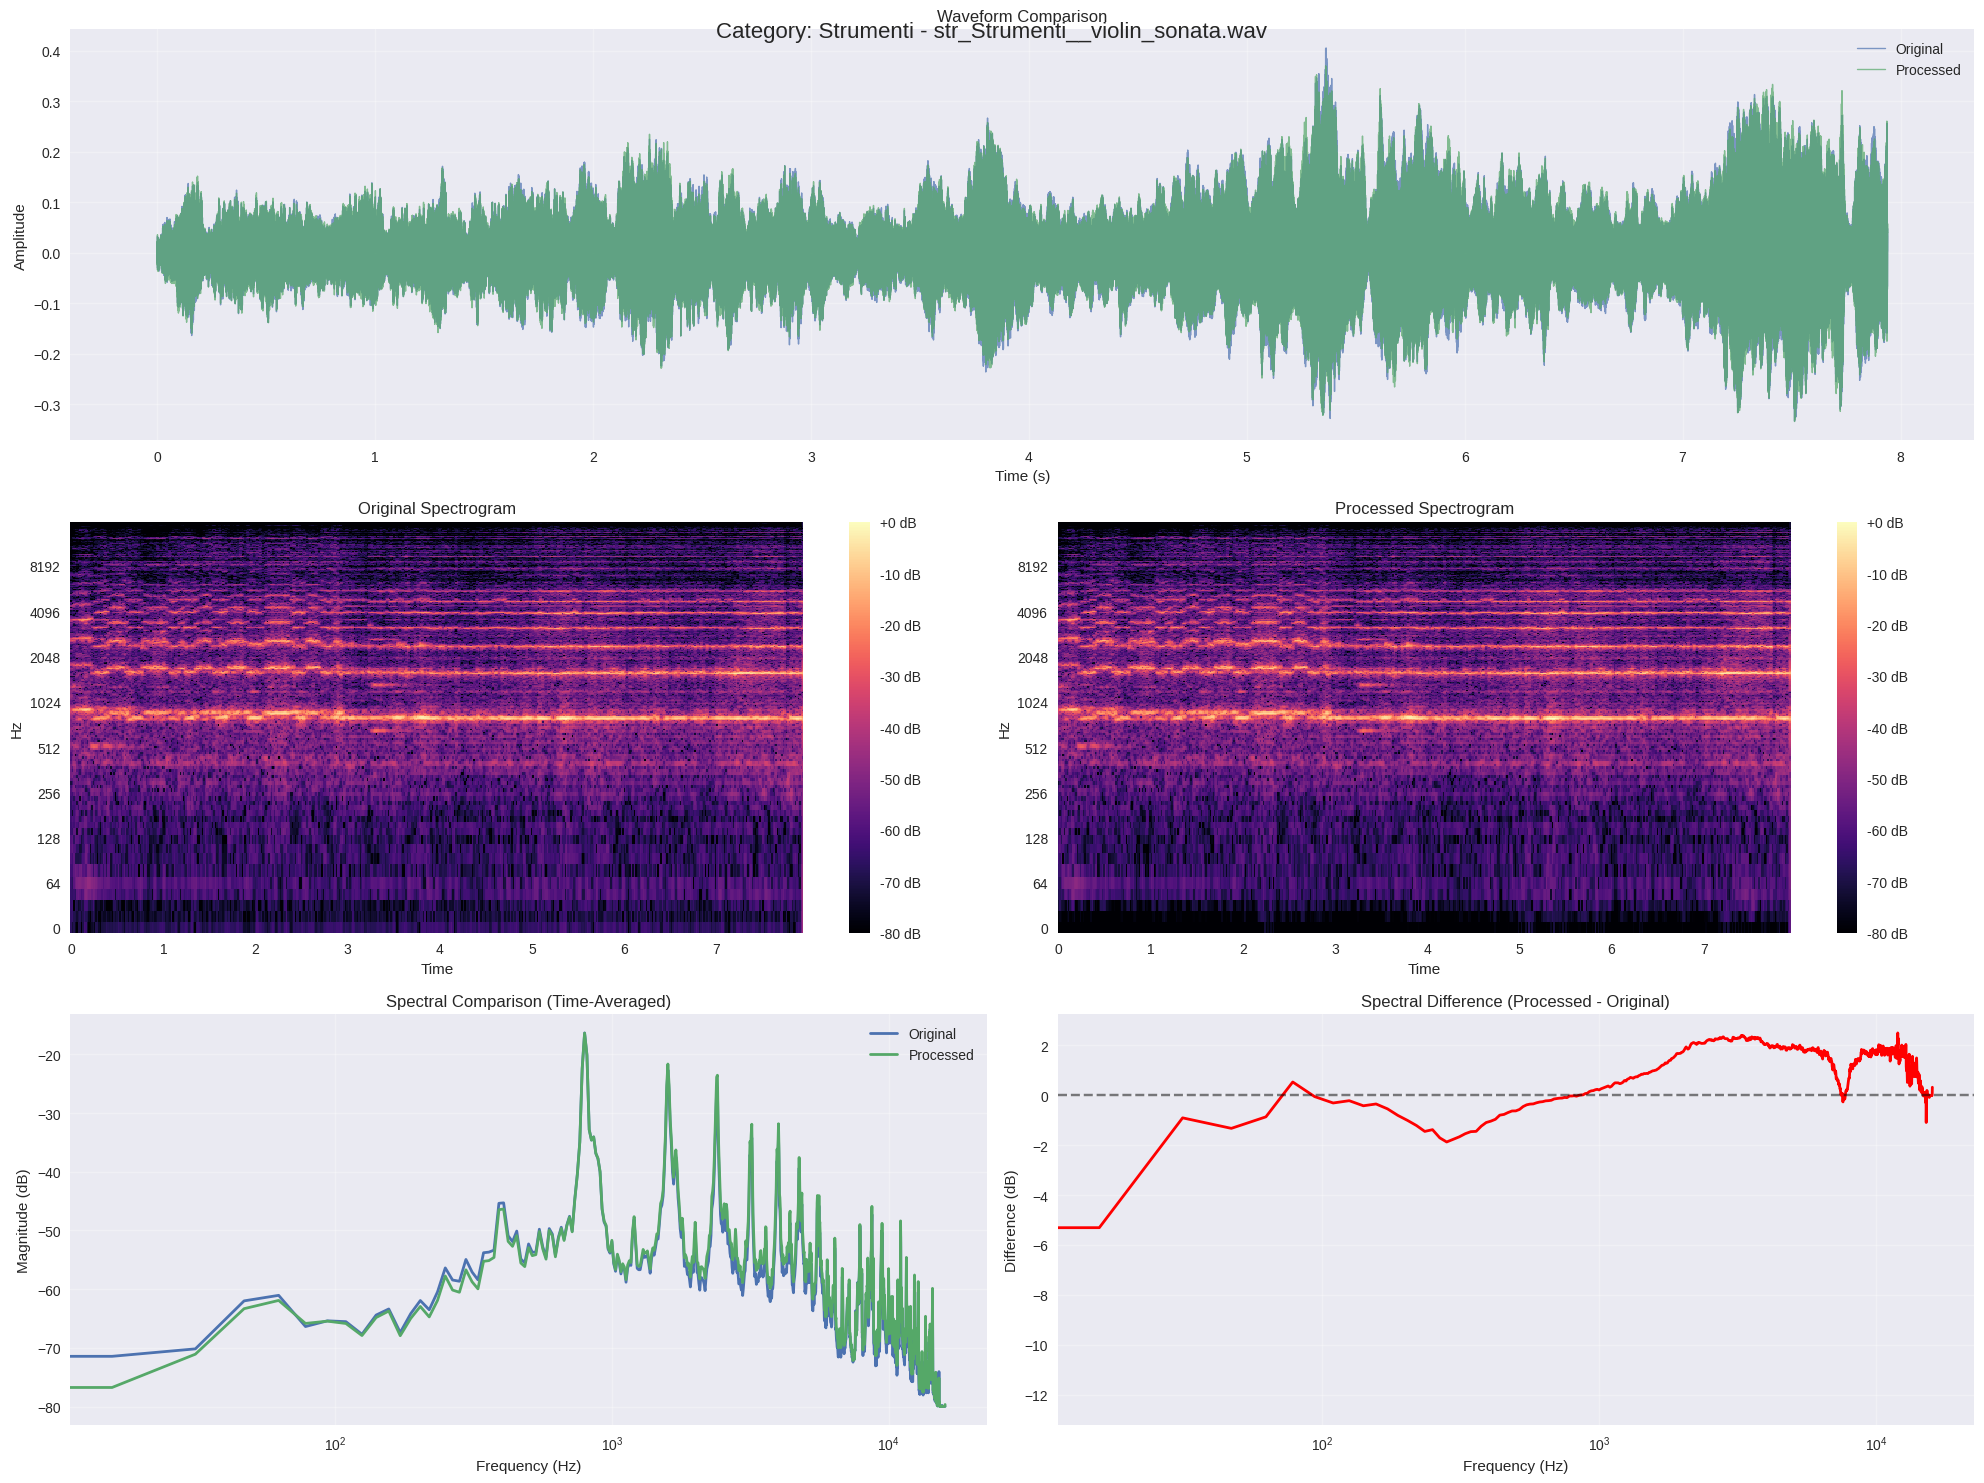

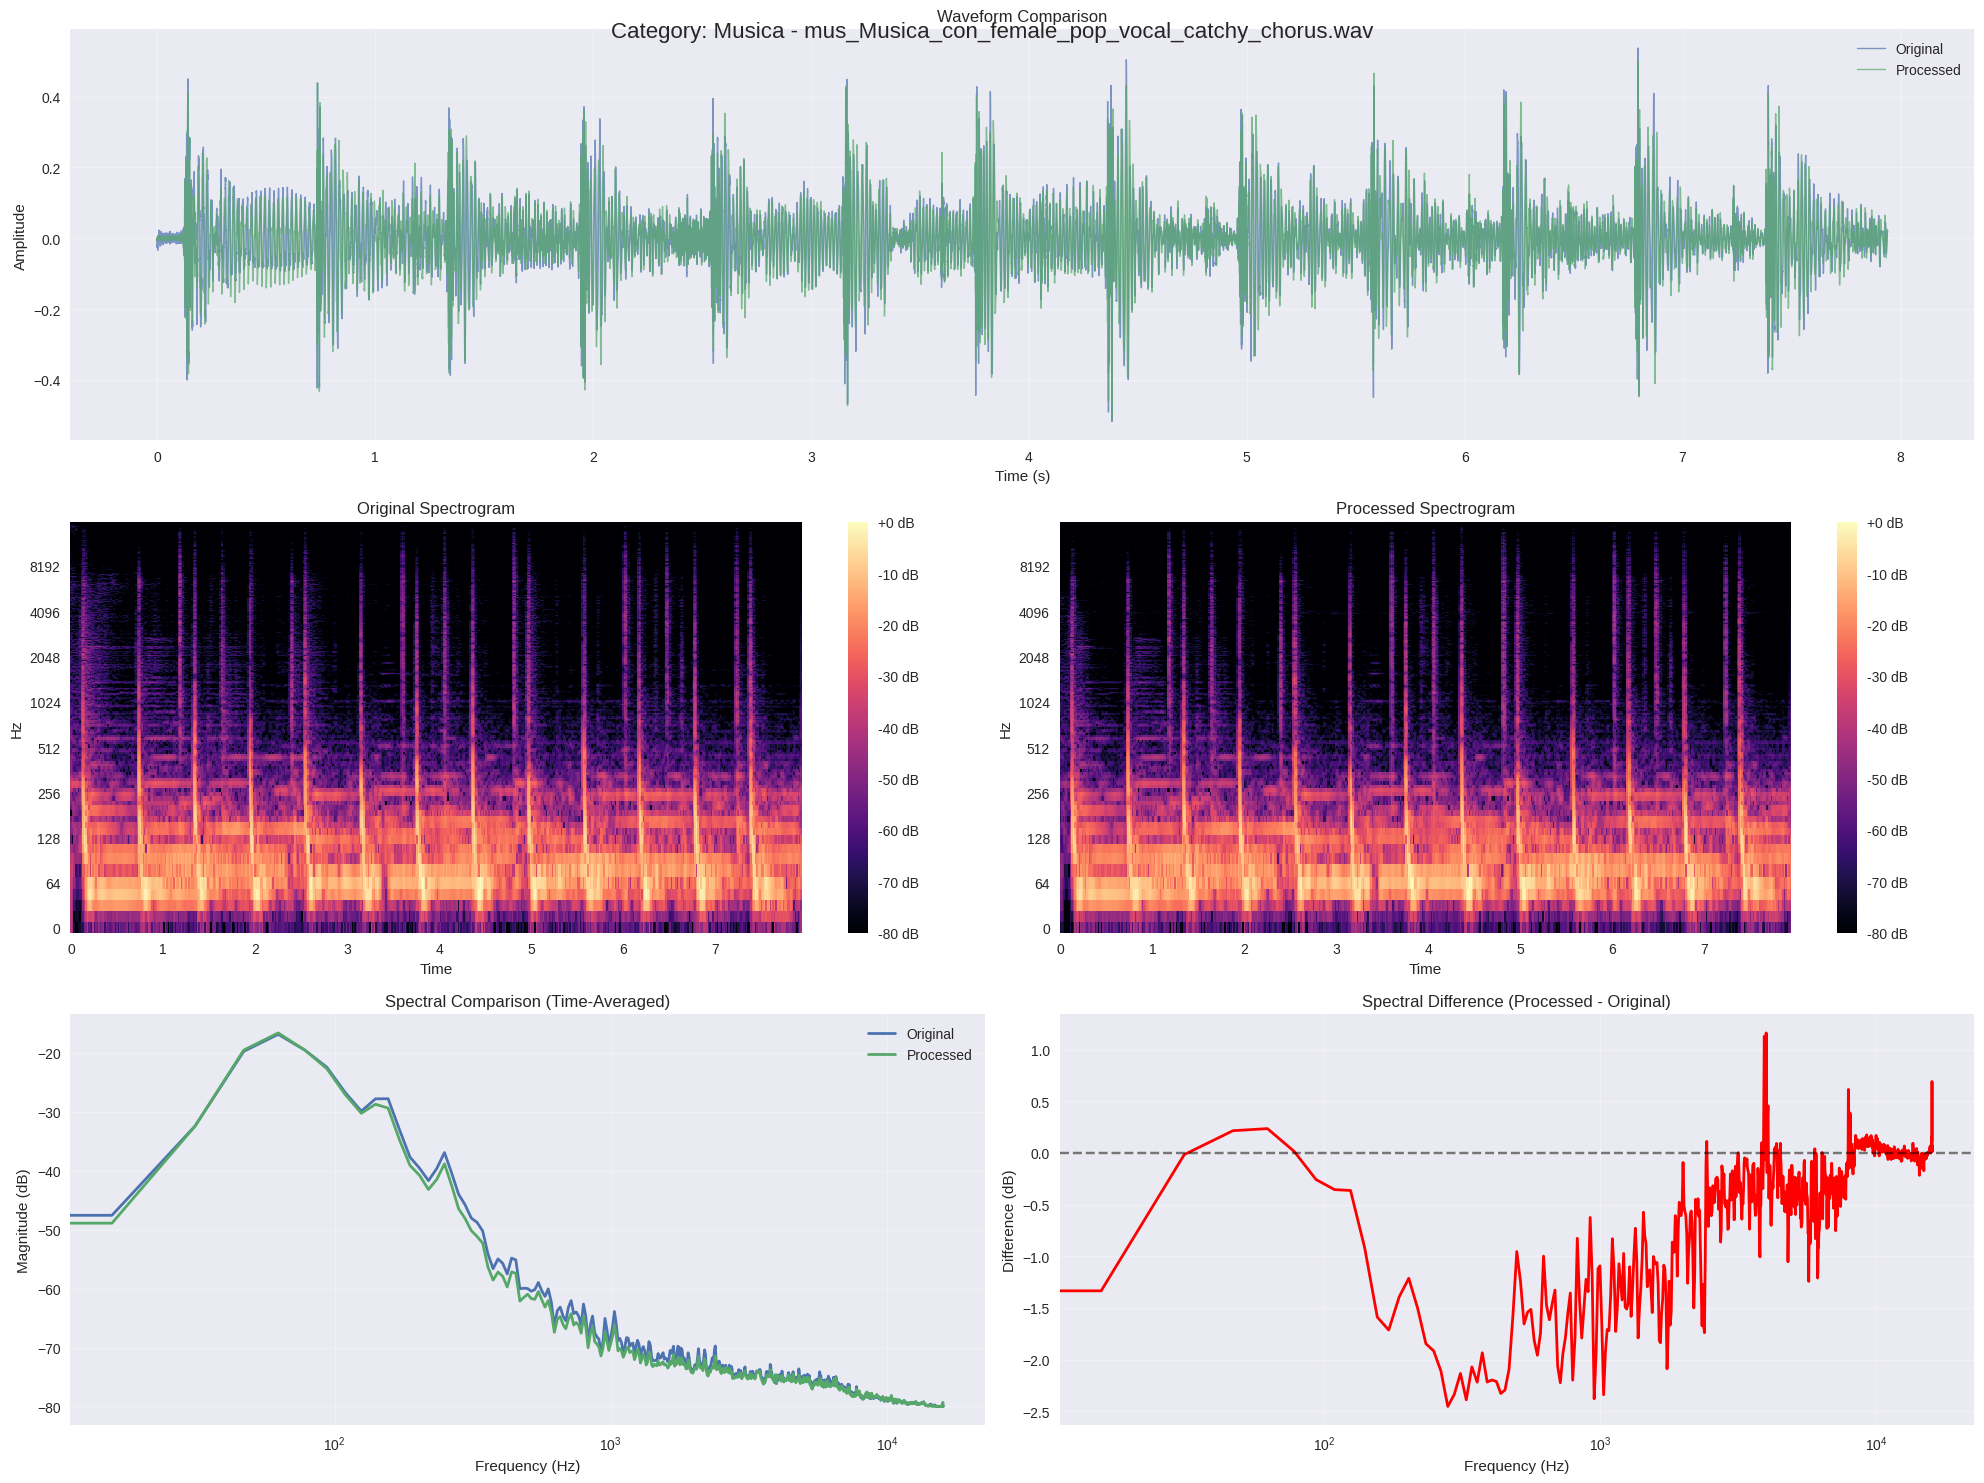

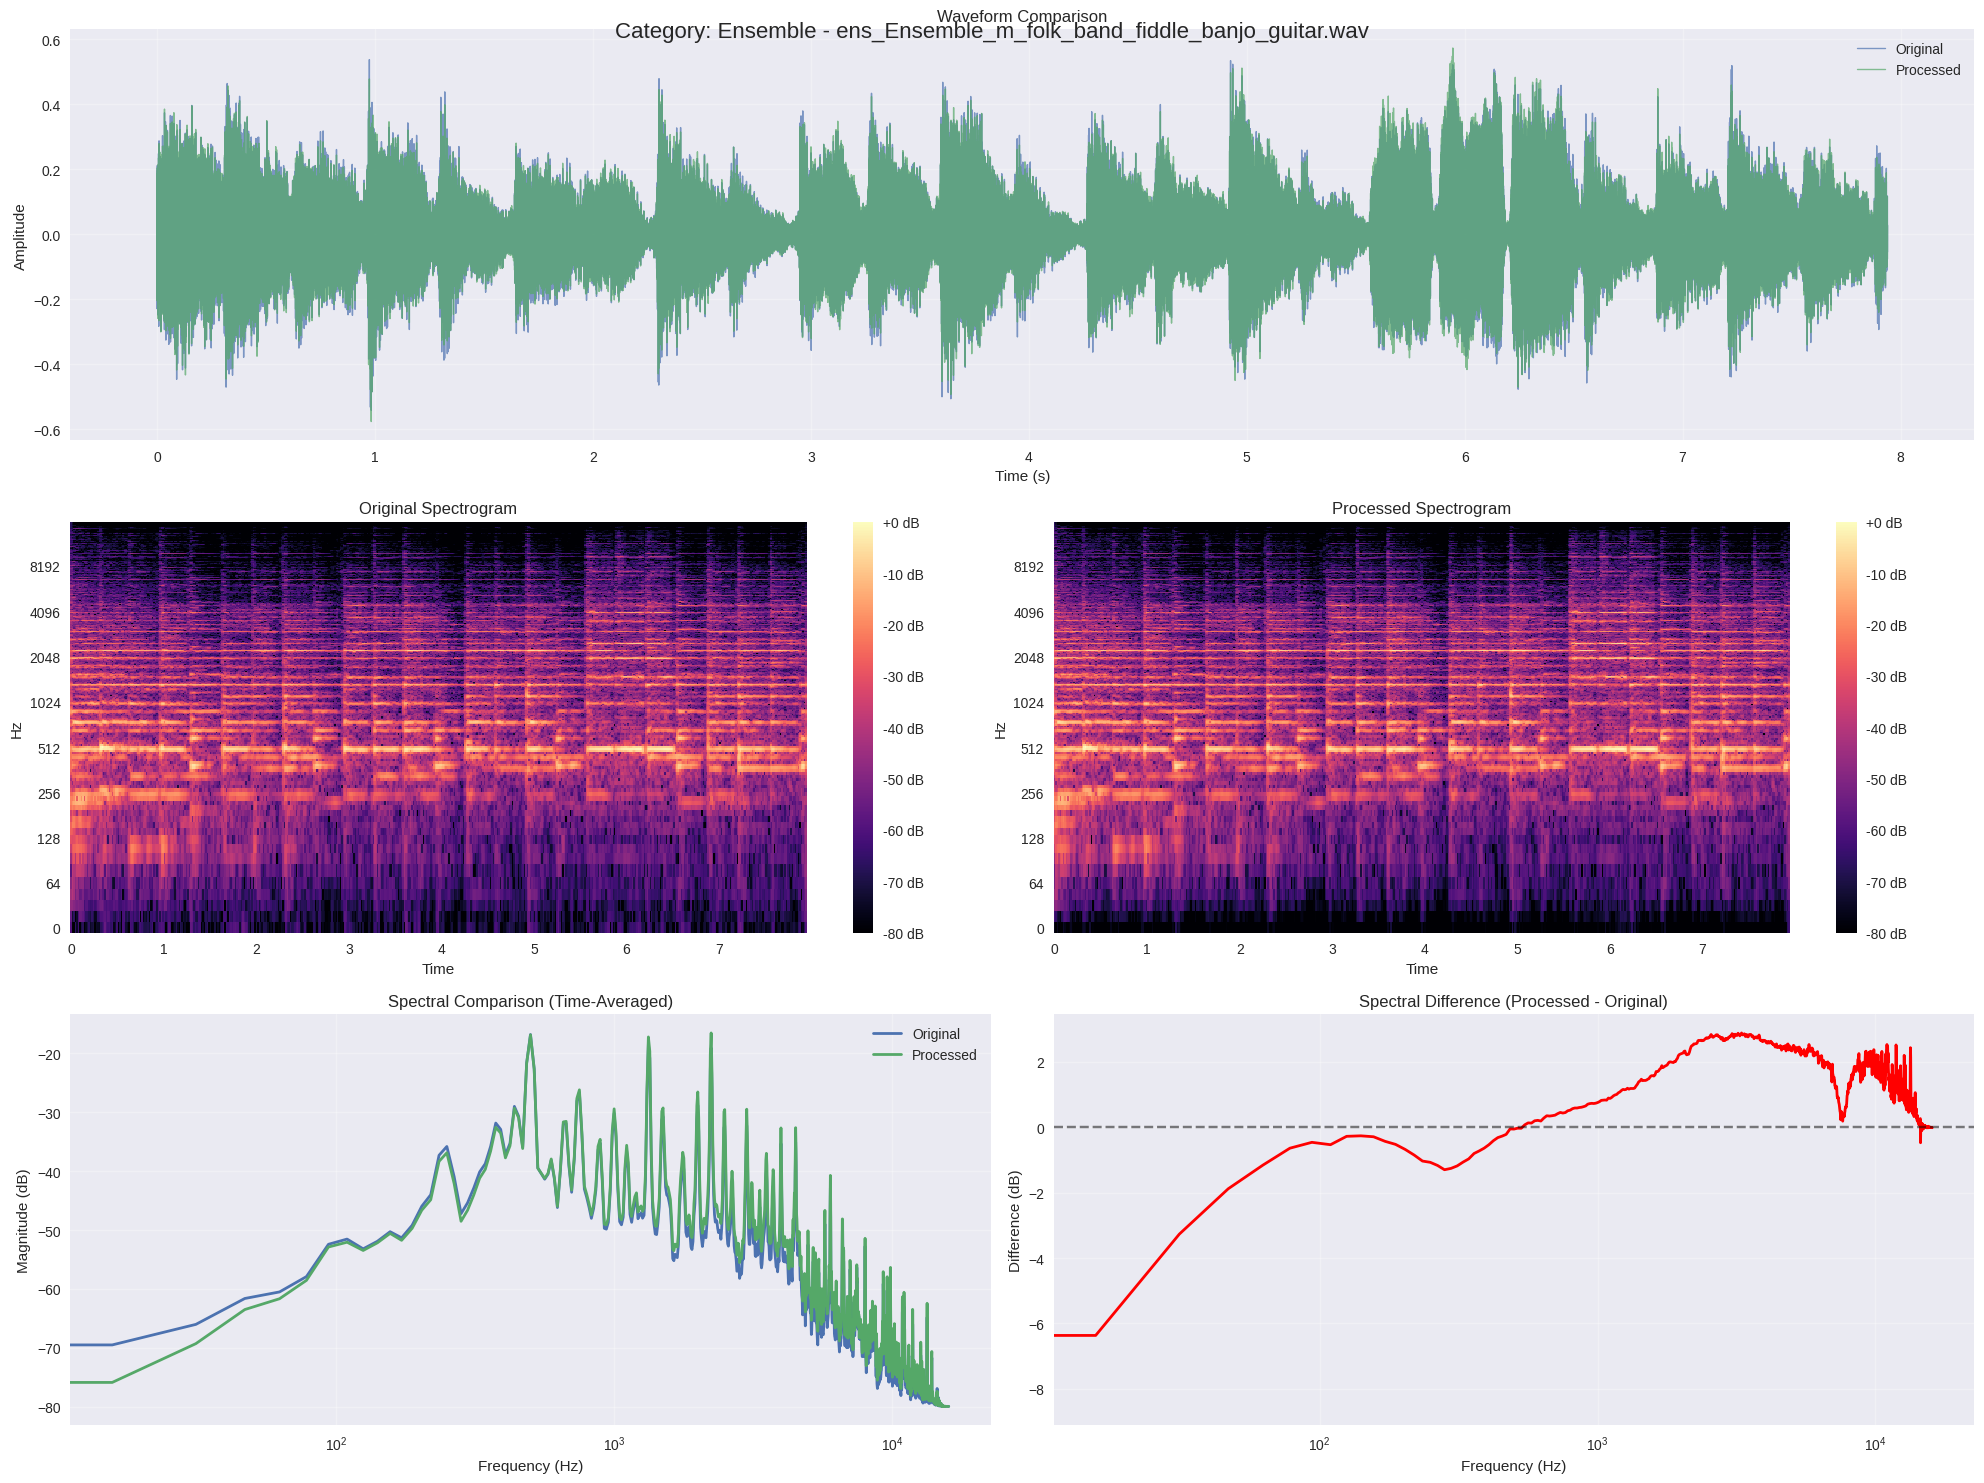

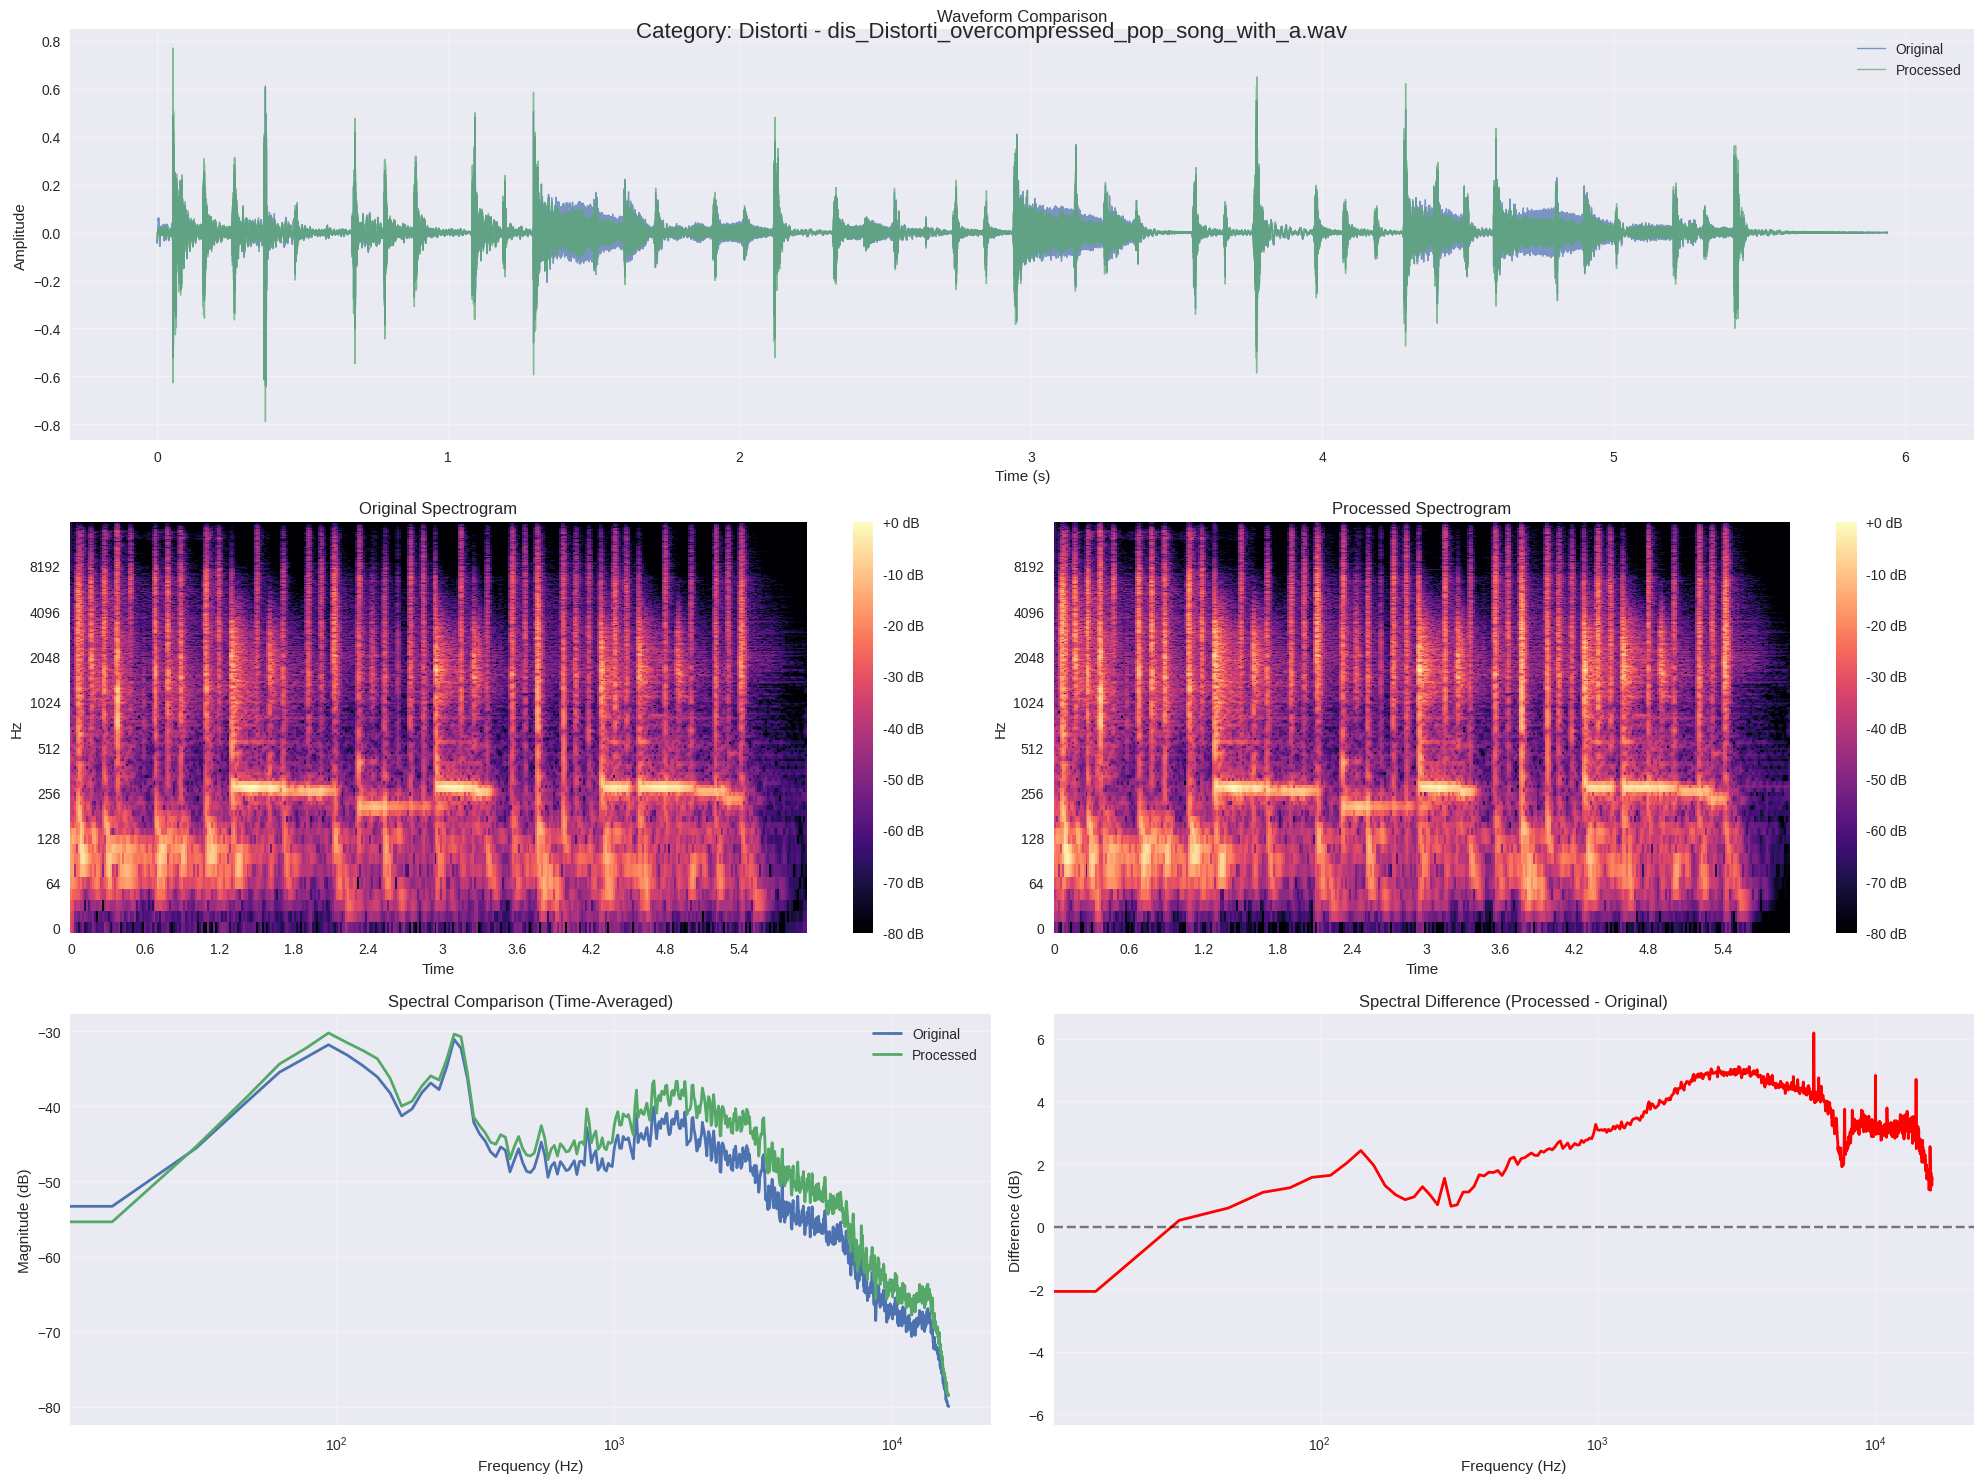

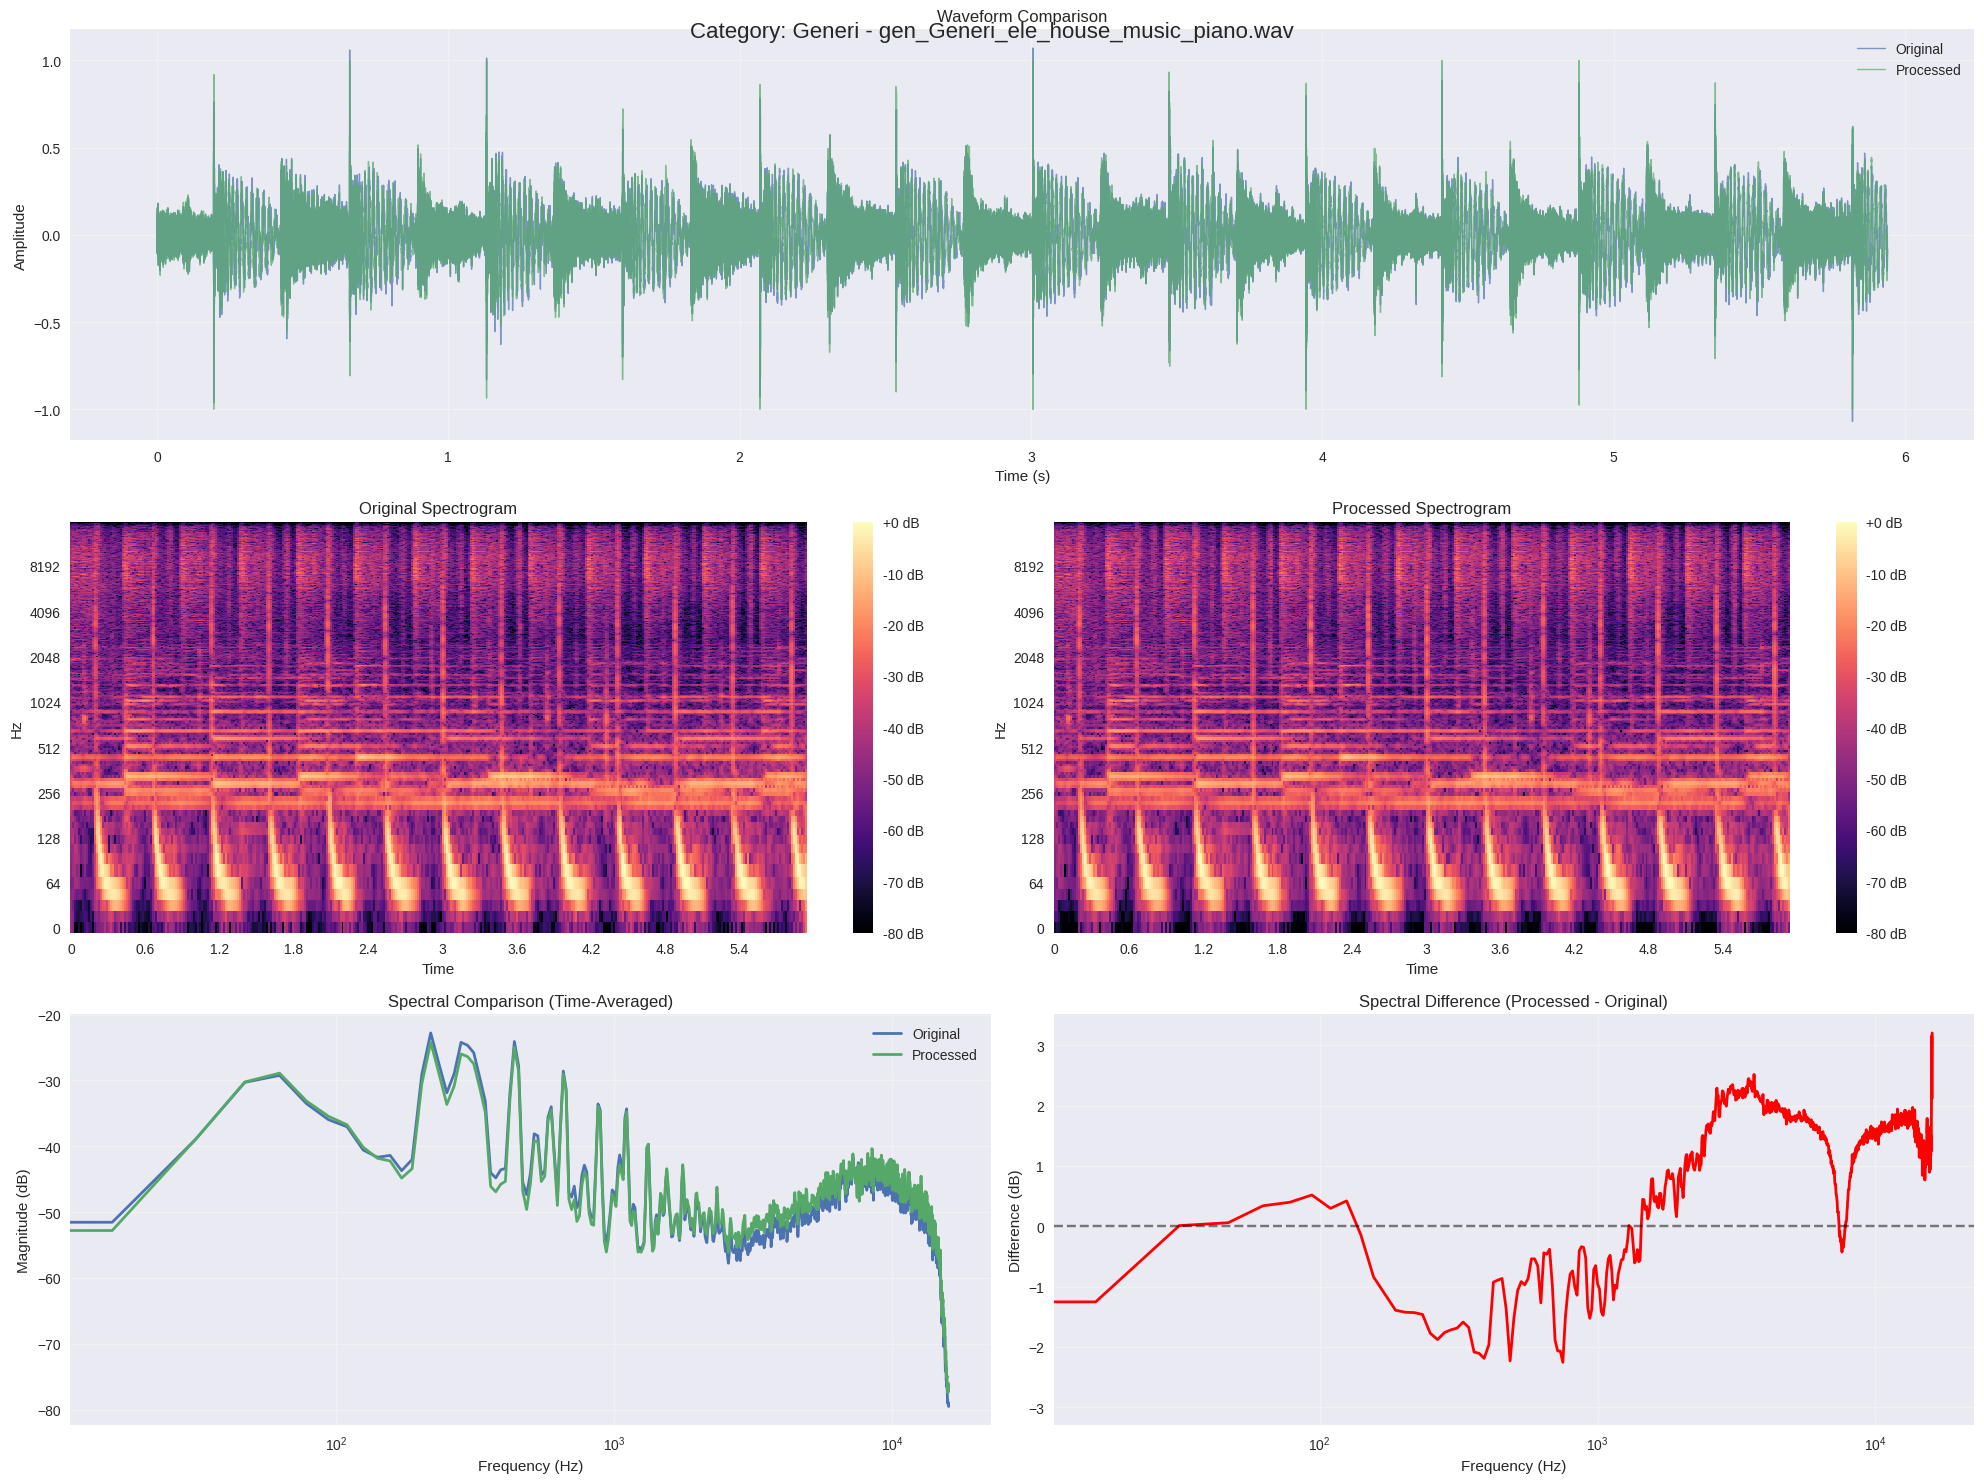

In [14]:
if __name__ == "__main__":
    main()